# **Homework 5 - Sequence-to-sequence**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com

### (4/14 Updates) 
1. Link to tutorial [video](https://youtu.be/htG5WpZVQPU).
2. Now defaults to load `"avg_last_5_checkpoint.pt"` to generate prediction.
3. Expected run time on Colab with Tesla T4

|Baseline|Details|Total Time|
|-|:-:|:-:|
|Simple|2m 15s $\times$30 epochs|1hr 8m|
|Medium|4m $\times$30 epochs|2hr|
|Strong|8m $\times$30 epochs (backward)<br>+1hr (back-translation)<br>+15m $\times$30 epochs (forward)|12hr 30m|

# Sequence-to-Sequence 介紹
- 大多數常見的 seq2seq model 為 encoder-decoder model，主要由兩個部分組成，分別是 encoder 和 decoder，而這兩個部可以使用 recurrent neural network (RNN)或 transformer 來實作，主要是用來解決輸入和輸出的長度不一樣的情況
- **Encoder** 是將一連串的輸入，如文字、影片、聲音訊號等，編碼為單個向量，這單個向量可以想像為是整個輸入的抽象表示，包含了整個輸入的資訊
- **Decoder** 是將 encoder 輸出的單個向量逐步解碼，一次輸出一個結果，直到將最後目標輸出被產生出來為止，每次輸出會影響下一次的輸出，一般會在開頭加入 "< BOS >" 來表示開始解碼，會在結尾輸出 "< EOS >" 來表示輸出結束


![seq2seq](https://i.imgur.com/0zeDyuI.png)

# 作業介紹
- 英文翻譯中文
  - 輸入： 一句英文 （e.g.		tom is a student .） 
  - 輸出： 中文翻譯 （e.g. 		湯姆 是 個 學生 。）

- TODO
  - 訓練一個 RNN 模型達到 Seq2seq 翻譯
  - 訓練一個 Transformer 大幅提升效能
  - 實作 Back-translation 大幅提升效能

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 下載和引入需要的函式庫

In [ ]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets

Requirement already up-to-date: jupyter in /usr/local/lib/python3.7/dist-packages (1.0.0)
Requirement already up-to-date: ipywidgets in /usr/local/lib/python3.7/dist-packages (7.6.3)


In [ ]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

fatal: destination path 'fairseq' already exists and is not an empty directory.
HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Processing ./fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for fairseq: filename=fairseq-1.0.0a0+9a1c497-cp37-cp37m-linux_x86_64.whl size=2817693 sha256=534af867d82f0f82d538eaa7270824031f6e7397c647383dd7f7874f493f94e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-jnbfupvq/wheels/94/b2/67/6399f5bcb823dc3a8b1e84965aaae15af9ed863fee98a59129
Successfully built fairseq
  Found existing installation: fairseq 1.0.0a0+9a1c497
    Uninstalling fairseq-1.0.0a0+9a1c497:
      Successfully uninstalled fairseq-1.0.0a0+9a1c497


In [ ]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# 設定種子

In [ ]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
!nvidia-smi

Thu Apr 22 08:41:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 資料集介紹

## 英轉繁雙語資料
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - 原始資料量: 398,066句    
    - 處理後資料: 393,980句
    

## 測試資料
- 資料量: 4,000句
- **中文部分不公開，提供的檔案為假翻譯，全部都是句點。**

# 資料下載

### 安裝megatools (optional)

In [ ]:
!apt-get install megatools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  megatools
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 148 kB of archives.
After this operation, 1,097 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 megatools amd64 1.9.98-1build2 [148 kB]
Fetched 148 kB in 0s (1,963 kB/s)
Selecting previously unselected package megatools.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../megatools_1.9.98-1build2_amd64.deb ...
Unpacking megatools (1.9.98-1build2) ...
Setting up megatools (1.9.98-1build2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


## 下載檔案並解壓縮

In [ ]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A"', 
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214987&authkey=AA4qP_azsicwZZM"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted2020.tgz",
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/test.tgz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U",
#     "https://mega.nz/#!zNcnGIoJ!oPJX9AvVVs11jc0SaK6vxP_lFUNTkEcK2WbxJpvjU5Y",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

--2021-04-22 08:41:23--  https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A
Resolving onedrive.live.com (onedrive.live.com)... 13.107.43.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.43.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://yva8og.dm.files.1drv.com/y4mY1OIbnPnKh7p6Ka4847sLwekRHtSI7EtIN8dBWV9lhz4l_WjbLYQVCHr4fpy3fD1w6VWMsRcXTnJA-SV-3FEW1D_zavc0V_FrqFjHDHwcs5vzH2d9DxFlImmh9d_VjpxSHZnqYlMUPsUYjuk_ABs4A2mHe0tzLiaJF9ND96ZS2iH8g1q0UkOP43wrVtpOJSDIjmzO_L1nWeka0E4S4N3oA/ted2020.tgz?download&psid=1 [following]
--2021-04-22 08:41:23--  https://yva8og.dm.files.1drv.com/y4mY1OIbnPnKh7p6Ka4847sLwekRHtSI7EtIN8dBWV9lhz4l_WjbLYQVCHr4fpy3fD1w6VWMsRcXTnJA-SV-3FEW1D_zavc0V_FrqFjHDHwcs5vzH2d9DxFlImmh9d_VjpxSHZnqYlMUPsUYjuk_ABs4A2mHe0tzLiaJF9ND96ZS2iH8g1q0UkOP43wrVtpOJSDIjmzO_L1nWeka0E4S4N3oA/ted2020.tgz?download&psid=1
Resolving yva8og.dm.files.1drv.com (yva8og.dm.files.1drv.com).

## 設定語言

In [ ]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [ ]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## 檔案前處理

In [ ]:
import re

def strQ2B(ustring):
    """把字串全形轉半形"""
    # 參考來源:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # 全形空格直接轉換
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # 全形字元（除空格）根據關係轉化
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [ ]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

In [ ]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## 切出 train/valid set

In [ ]:
valid_ratio = 0.01 # 3000~4000句就夠了
train_ratio = 1 - valid_ratio

In [ ]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

## Subword Units 
翻譯存在的一大問題是未登錄詞(out of vocabulary)，可以使用 subword units 作為斷詞單位來解決。
- 使用 [sentencepiece](#kudo-richardson-2018-sentencepiece) 套件
- 用 unigram 或 byte-pair encoding (BPE)

In [ ]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' 也可
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

In [ ]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

In [ ]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5
print(data_dir+'/'+dataset_name+'/train.'+src_lang)
print(data_dir+'/'+dataset_name+'/train.'+tgt_lang)


▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁ ; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl own ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁ 。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁ 。 ▁我 非常 感 激 ▁ 。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對 我 之前 演講 的 好 評 ▁ 。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁ !
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁ !
./DATA/rawdata/ted2020/train.en
./DATA/rawdata/ted2020/train.zh


## 用 fairseq 將資料轉為 binary

In [ ]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

2021-04-22 08:45:10 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/ted2020', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=True, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='en', srcdict=None, suppress_crashes=False, target_lang='zh', task='translation', tensorboard_logdir=None, testpref='/content/DATA/rawdata/ted2020/test', tgtdict=None, threshold_loss_scale=None, thresholdsrc=0, t

# 實驗的參數設定表

In [ ]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020_with_mono", #"./DATA/data-bin/ted2020", #"./DATA/data-bin/ted2020_with_mono",
    savedir = "./checkpoints/rnn-bt", # "./checkpoints/rnn-back", #"./checkpoints/rnn-bt",  #, #./checkpoints/rnn 
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=60,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging 套件紀錄一般訊息
- wandb 紀錄續練過程 loss, bleu, model weight 等等

In [ ]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA環境

In [ ]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2021-04-22 08:55:21 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2021-04-22 08:55:21 | INFO | fairseq.utils | rank   0: capabilities =  7.0  ; total memory = 15.782 GB ; name = Tesla V100-SXM2-16GB                    
2021-04-22 08:55:21 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# 讀取資料集

## 借用 fairseq 的 TranslationTask
* 用來讀進上面 binarized 的檔案
* 有現成的 data iterator (dataloader)
* 字典 task.source_dictionary 和 task.target_dictionary 也很好用 
* 有實做 beam search

In [ ]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-04-22 08:55:21 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2021-04-22 08:55:21 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [ ]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-04-22 08:55:21 | INFO | hw5.seq2seq | loading data for epoch 1
2021-04-22 08:55:21 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.en
2021-04-22 08:55:21 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.zh
2021-04-22 08:55:21 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train en-zh 390041 examples
2021-04-22 08:55:21 | INFO | fairseq.data.data_utils | loaded 782,527 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en
2021-04-22 08:55:21 | INFO | fairseq.data.data_utils | loaded 782,527 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh
2021-04-22 08:55:21 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train1 en-zh 782527 examples
2021-04-22 08:55:21 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020_with_mono/valid.en-zh.en
2021-04-22 08:55:21 | I

In [ ]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  18,   14,    6, 2218,   60,   19,   75,    4,  253,   16,  334, 1392,
        1689,    7,    2]),
 'target': tensor([ 145,  684,   30,  270,   40,  168, 1134,  650,  591,  367, 3117, 2417,
        1420,  194,    2])}
"Source: that's exactly what i do optical mind control ."
'Target: 這實在就是我所做的--光學操控思想'


## Dataset Iterator

* 將每個 batch 控制在 N 個 token 讓 GPU 記憶體更有效被利用
* 讓 training set 每個 epoch 有不同 shuffling
* 濾掉長度太長的句子
* 將每個 batch 內的句子 pad 成一樣長，好讓 GPU 平行運算
* 加上 eos 並 shift 一格
    - teacher forcing: 為了訓練模型根據prefix生成下個字，decoder的輸入會是輸出目標序列往右shift一格。
    - 一般是會在輸入開頭加個bos token (如下圖)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - fairseq 則是直接把 eos 挪到 beginning，訓練起來效果其實差不多。例如: 
    ```
    # 輸出目標 (target) 和 Decoder輸入 (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```


In [ ]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2021-04-22 08:55:21 | WARNING | fairseq.tasks.fairseq_task | 2,586 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[29, 2444, 135, 3058, 93, 2275, 682, 2649, 731, 1623]


{'id': tensor([3200,  828]),
 'net_input': {'prev_output_tokens': tensor([[   2,    4,  237, 1769,    9,  494,  491,  670,    4,   10,    1,    1,
              1,    1,    1,    1],
          [   2,    4,  325, 1974,  793,  294,  289,  596,    4,   10,    1,    1,
              1,    1,    1,    1]]),
  'src_lengths': tensor([8, 8]),
  'src_tokens': tensor([[ 159, 2479,   17,  131,   72,  733,    7,    2],
          [  81,    4, 1709,    4,  862,  718,    7,    2]])},
 'nsentences': 2,
 'ntokens': 20,
 'target': tensor([[   4,  237, 1769,    9,  494,  491,  670,    4,   10,    2,    1,    1,
             1,    1,    1,    1],
         [   4,  325, 1974,  793,  294,  289,  596,    4,   10,    2,    1,    1,
             1,    1,    1,    1]])}

* 每個 batch 是一個字典，key 是字串，value 是 Tensor，內容說明如下
```python
batch = {
    "id": id, # 每個 example 的 id
    "nsentences": len(samples), # batch size 句子數
    "ntokens": ntokens, # batch size 字數
    "net_input": {
        "src_tokens": src_tokens, # 來源語言的序列
        "src_lengths": src_lengths, # 每句話沒有 pad 過的長度
        "prev_output_tokens": prev_output_tokens, # 上面提到右 shift 一格後的目標序列
    },
    "target": target, # 目標序列
}
```

# 定義模型架構
* 我們一樣繼承 fairseq 的 encoder, decoder 和 model, 這樣測試階段才能直接用他寫好的 beam search 函式

In [ ]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Encoder 編碼器

- seq2seq 模型的編碼器為 RNN 或 Transformer Encoder，以下說明以 RNN 為例，Transformer 略有不同。對於每個輸入，Encoder 會輸出一個向量和一個隱藏狀態(hidden state)，並將隱藏狀態用於下一個輸入。換句話說，Encoder 會逐步讀取輸入序列，並在每個 timestep 輸出單個向量，以及在最後 timestep 輸出最終隱藏狀態(content vector)
- 參數:
  - *args*
      - encoder_embed_dim 是 embedding 的維度，主要將 one-hot vector 的單詞向量壓縮到指定的維度，主要是為了降維和濃縮資訊的功用
      - encoder_ffn_embed_dim 是 RNN 輸出和隱藏狀態的維度(hidden dimension)
      - encoder_layers 是 RNN 要疊多少層
      - dropout 是決定有多少的機率會將某個節點變為 0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不使用
  - *dictionary*: fairseq 幫我們做好的 dictionary. 在此用來得到 padding index，好用來得到 encoder padding mask. 
  - *embed_tokens*: 事先做好的詞嵌入 (nn.Embedding)

- 輸入: 
    - *src_tokens*: 英文的整數序列 e.g. 1, 28, 29, 205, 2 
- 輸出: 
    - *outputs*: 最上層 RNN 每個 timestep 的輸出，後續可以用 Attention 再進行處理
    - *final_hiddens*: 每層最終 timestep 的隱藏狀態，將傳遞到 Decoder 進行解碼
    - *encoder_padding_mask*: 告訴我們哪些是位置的資訊不重要。


In [ ]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # 過雙向RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions] 是最上層RNN的輸出
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # 這個beam search時會用到，意義並不是很重要
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- 當輸入過長，或是單獨靠 “content vector” 無法取得整個輸入的意思時，用 Attention Mechanism 來提供 Decoder 更多的資訊
- 根據現在 **Decoder embeddings** ，去計算在 **Encoder outputs** 中，那些與其有較高的關係，根據關係的數值來把 Encoder outputs 平均起來作為 **Decoder** RNN 的輸入 
- 常見 Attention 的實作是用 Neural Network / Dot Product 來算 **query** (decoder embeddings) 和 **key** (Encoder outputs) 之間的關係，再對所有算出來的數值做 **softmax** 得到分佈，最後根據這個分佈對 **values** (Encoder outputs) 做 **weight sum**

- 參數:
  - *input_embed_dim*: key 的維度，應是 decoder 要做 attend 時的向量的維度
  - *source_embed_dim*: query 的維度，應是要被 attend 的向量(encoder outputs)的維度
  - *output_embed_dim*: value 的維度，應是做完 attention 後，下一層預期的向量維度

- 輸入: 
    - *inputs*: 就是 key，要 attend 別人的向量
    - *encoder_outputs*: 是 query/value，被 attend 的向量
    - *encoder_padding_mask*: 告訴我們哪些是位置的資訊不重要。
- 輸出: 
    - *output*: 做完 attention 後的 context vector
    - *attention score*: attention 的分布


In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # 投影到encoder_outputs的維度
        x = self.input_proj(inputs)

        # 計算attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # 擋住padding位置的attention
        if encoder_padding_mask is not None:
            # 利用broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # 在source對應維度softmax
        attn_scores = F.softmax(attn_scores, dim=-1)

        # 形狀 (B, T, S) x (B, S, dim) = (B, T, dim) 加權平均
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # 回復形狀 (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

## Decoder 解碼器

* 解碼器的 hidden states 會用編碼器最終隱藏狀態來初始化(content vector)
* 解碼器同時也根據目前 timestep 的輸入(也就是前幾個 timestep 的 output)，改變 hidden states，並輸出結果 
* 如果加入 attention 可以使表現更好
* 我們把 seq2seq 步驟寫在解碼器裡，好讓等等 Seq2Seq 這個型別可以通用 RNN 和 Transformer，而不用再改寫
- 參數:
  - *args*
      - decoder_embed_dim 是解碼器 embedding 的維度，類同 encoder_embed_dim，
      - decoder_ffn_embed_dim 是解碼器 RNN 的隱藏維度，類同 encoder_ffn_embed_dim
      - decoder_layers 解碼器 RNN 的層數
      - share_decoder_input_output_embed 通常 decoder 最後輸出的投影矩陣會和輸入 embedding 共用參數
  - *dictionary*: fairseq 幫我們做好的 dictionary.
  - *embed_tokens*: 事先做好的詞嵌入(nn.Embedding)
- 輸入: 
    - *prev_output_tokens*: 英文的整數序列 e.g. 1, 28, 29, 205, 2 已經 shift 一格的 target
    - *encoder_out*: 編碼器的輸出
    - *incremental_state*: 這是測試階段為了加速，所以會記錄每個 timestep 的 hidden state 詳見 forward
- 輸出: 
    - *outputs*: decoder 每個 timestep 的 logits，還沒經過 softmax 的分布
    - *extra*: 沒用到

In [ ]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # 取出encoder的輸出
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # 有上個timestep留下的資訊，讀進來就可以繼續decode，不用從bos重來
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # 沒有incremental state代表這是training或者是test time時的第一步
            # 準備seq2seq: 把encoder_hiddens pass進去decoder的hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # 做decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # 過單向RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # 投影到embedding size (如果hidden 和embed size不一樣，然後share_embedding又設成True,需要額外project一次)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # 投影到vocab size 的分佈
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # 如果是Incremental, 記錄這個timestep的hidden states, 下個timestep讀回來
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # 這個beam search時會用到，意義並不是很重要
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- 由 **Encoder** 和 **Decoder** 組成
- 接收輸入並傳給 **Encoder** 
- 將 **Encoder** 的輸出傳給 **Decoder**
- **Decoder** 根據前幾個 timestep 的輸出和 **Encoder** 輸出進行解碼  
- 當解碼完成後，將 **Decoder** 的輸出傳回 

In [ ]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# 模型初始化

In [ ]:
# # HINT: transformer 架構
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ 按照參數設定建置模型 """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # 詞嵌入
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # 編碼器與解碼器
    # TODO: 替換成 TransformerEncoder 和 TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # 序列到序列模型
    model = Seq2Seq(args, encoder, decoder)
    
    # 序列到序列模型的初始化很重要 需要特別處理
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # 初始化模型
    model.apply(init_params)
    return model

## 設定模型相關參數
參考參數

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|

Strong baseline 用的參數可以參考 [Attention is all you need](#vaswani2017) 的 Table 3 的 transformer-base

In [ ]:
arch_args = Namespace(
    encoder_embed_dim=512,
    encoder_ffn_embed_dim=2048,
    encoder_layers=8,
    decoder_embed_dim=512,
    decoder_ffn_embed_dim=2048,
    decoder_layers=8,
    share_decoder_input_output_embed=True,
    dropout=0.35,
)

# # HINT: 補上Transformer用的參數
def add_transformer_args(args):
    args.encoder_attention_heads=8
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=8
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # 補上我們沒有設定的Transformer預設參數
    from fairseq.models.transformer import base_architecture 
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [ ]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [ ]:
model = build_model(arch_args, task)
logger.info(model)

2021-04-22 08:55:23 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 512, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bia

# Optimization 最佳化

## Loss: Label Smoothing Regularization
* 讓模型學習輸出較不集中的分佈，防止模型過度自信
* 有時候Ground Truth並非唯一答案，所以在算loss時，我們會保留一部份機率給正確答案以外的label
* 可以有效防止過度擬合

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [ ]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，當目標是one-hot時的cross-entropy loss. 以下同 F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        # 將一部分正確答案的機率分配給其他label 所以當計算cross-entropy時等於把所有label的log prob加起來
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # 計算cross-entropy時 加入分配給其他label的loss
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# 一般都用0.1效果就很好了
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root 排程對於訓練 Transformer 時的穩定性很重要，後來也用在 RNN 上。
根據底下公式來更新 learning rate，前期線性增長，後期根據更新步數方根的倒數來遞減。
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$
code [source](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [ ]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

## 排程視覺化

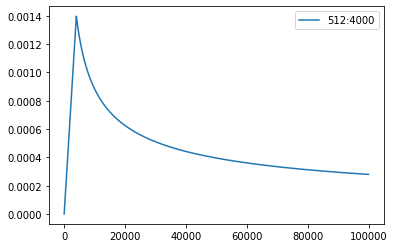

In [ ]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# 訓練步驟

## Training 訓練

In [ ]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # 梯度累積: 每 accum_steps 個 sample 更新一次
    
    stats = {"loss": []}
    scaler = GradScaler() # 混和精度訓練 automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # 梯度累積: 每 accum_steps 個 sample 更新一次
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # 混和精度訓練 
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # 梯度裁剪 防止梯度爆炸
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference 檢驗和推論
為防止訓練發生過度擬合，每過一段時間要做一次檢測，計算模型在未看過的資料上的表現。
- 過程基本上和training一樣，另外加上 inference
- 檢驗完畢可順便儲存模型參數

單看 validation loss，我們很難知道模型真實的效能
- 直接用當前模型去生成翻譯結果 (hypothesis)，再和正確答案 (reference) 計算 BLEU score
- 也可用肉眼看翻譯結果的好壞
- 我們用 fairseq 寫好的 sequence generator 來進行 beam search 生成翻譯結果

In [ ]:
# fairseq 的 beam search generator
# 給定模型和輸入序列，用 beam search 生成翻譯結果
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # 從 Tensor 轉成人看得懂的句子
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # 對於每個 sample, 收集輸入，輸出和參考答案，稍後計算 BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 代表取出 beam 內分數第一的輸出結果
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [ ]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # 進行推論
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# 儲存及載入模型參數

In [ ]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# 主程式
## 訓練迴圈

In [ ]:
raise

In [ ]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [ ]:
!nvidia-smi

Thu Apr 22 08:56:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    39W / 300W |   1599MiB / 16160MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2021-04-22 08:56:06 | INFO | hw5.seq2seq | task: TranslationTask
2021-04-22 08:56:06 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2021-04-22 08:56:06 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2021-04-22 08:56:06 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2021-04-22 08:56:06 | INFO | hw5.seq2seq | optimizer: NoamOpt
2021-04-22 08:56:06 | INFO | hw5.seq2seq | num. model params: 67,045,376 (num. trained: 67,045,376)
2021-04-22 08:56:06 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [85]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)


2021-04-22 08:56:32 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2021-04-22 08:56:32 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/rnn-bt/checkpoint_last.pt!


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f70f75b2710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f70f75b2710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

2021-04-22 09:12:42 | INFO | hw5.seq2seq | training loss: 5.4868
2021-04-22 09:12:42 | INFO | hw5.seq2seq | begin validation


2021-04-22 09:13:12 | INFO | hw5.seq2seq | example source: right , it's gone ? or is it still up there ?
2021-04-22 09:13:12 | INFO | hw5.seq2seq | example hypothesis: 沒錯 , 是嗎 ? 或是它仍然存在 ?
2021-04-22 09:13:12 | INFO | hw5.seq2seq | example reference: 還是還在 ?
2021-04-22 09:13:12 | INFO | hw5.seq2seq | validation loss:	4.2196
2021-04-22 09:13:12 | INFO | hw5.seq2seq | BLEU = 13.48 50.8/24.1/12.3/6.6 (BP = 0.761 ratio = 0.785 hyp_len = 87809 ref_len = 111811)
2021-04-22 09:13:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint1.pt
2021-04-22 09:13:14 | INFO | hw5.seq2seq | end of epoch 1


2021-04-22 09:29:23 | INFO | hw5.seq2seq | training loss: 3.7075
2021-04-22 09:29:23 | INFO | hw5.seq2seq | begin validation


2021-04-22 09:29:59 | INFO | hw5.seq2seq | example source: it's a ways out still .
2021-04-22 09:29:59 | INFO | hw5.seq2seq | example hypothesis: 還能延伸出去
2021-04-22 09:29:59 | INFO | hw5.seq2seq | example reference: 這計畫目前還在進行 。
2021-04-22 09:29:59 | INFO | hw5.seq2seq | validation loss:	3.6517
2021-04-22 09:29:59 | INFO | hw5.seq2seq | BLEU = 20.75 55.2/29.2/16.4/9.6 (BP = 0.925 ratio = 0.928 hyp_len = 103761 ref_len = 111811)
2021-04-22 09:30:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint2.pt
2021-04-22 09:30:02 | INFO | hw5.seq2seq | end of epoch 2


2021-04-22 09:46:10 | INFO | hw5.seq2seq | training loss: 3.3051
2021-04-22 09:46:10 | INFO | hw5.seq2seq | begin validation


2021-04-22 09:46:42 | INFO | hw5.seq2seq | example source: fear not .
2021-04-22 09:46:42 | INFO | hw5.seq2seq | example hypothesis: 恐懼不是 。
2021-04-22 09:46:42 | INFO | hw5.seq2seq | example reference: 別怕 。
2021-04-22 09:46:42 | INFO | hw5.seq2seq | validation loss:	3.3616
2021-04-22 09:46:42 | INFO | hw5.seq2seq | BLEU = 23.61 57.7/32.0/18.6/11.3 (BP = 0.947 ratio = 0.948 hyp_len = 106044 ref_len = 111811)
2021-04-22 09:46:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint3.pt
2021-04-22 09:46:44 | INFO | hw5.seq2seq | end of epoch 3


2021-04-22 10:02:45 | INFO | hw5.seq2seq | training loss: 3.0743
2021-04-22 10:02:45 | INFO | hw5.seq2seq | begin validation


2021-04-22 10:03:17 | INFO | hw5.seq2seq | example source: and we had we zoned it , you know: we put a nightclub , we put a disco where you could dance , and then we had a place where you could fight with guns if you wanted to , and we had another place that was like a boardwalk , kind of a coney island .
2021-04-22 10:03:17 | INFO | hw5.seq2seq | example hypothesis: 我們把它放大了 , 你知道嗎 ? 我們放了一個夜店 , 我們放了一道菜餚 , 在那裡跳舞 , 然後我們有個地方 , 如果你想跟槍打架 , 我們還有另一個地方 , 像董事會 , 有點像是一個錐體島 。
2021-04-22 10:03:17 | INFO | hw5.seq2seq | example reference: 我們還規劃了夜店並且放了讓大家可以跳舞的迪斯可另外還有一個可以讓你和別人拿槍單挑的地方還有另一個地方有著又長又寬的走道 , 有點像是康尼島
2021-04-22 10:03:17 | INFO | hw5.seq2seq | validation loss:	3.2299
2021-04-22 10:03:17 | INFO | hw5.seq2seq | BLEU = 25.48 57.5/32.4/19.1/11.9 (BP = 1.000 ratio = 1.000 hyp_len = 111762 ref_len = 111811)
2021-04-22 10:03:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint4.pt
2021-04-22 10:03:19 | INFO | hw5.seq2seq | end of epoch 4


2021-04-22 10:19:17 | INFO | hw5.seq2seq | training loss: 2.9532
2021-04-22 10:19:17 | INFO | hw5.seq2seq | begin validation


2021-04-22 10:19:49 | INFO | hw5.seq2seq | example source: and there is no statistical difference between the white parents and the black parents .
2021-04-22 10:19:49 | INFO | hw5.seq2seq | example hypothesis: 而且在白人父母和黑人父母之間沒有統計上的差別 。
2021-04-22 10:19:49 | INFO | hw5.seq2seq | example reference: 在白人父母和黑人父母之間 , 也沒有什麼差別 ,
2021-04-22 10:19:49 | INFO | hw5.seq2seq | validation loss:	3.1643
2021-04-22 10:19:49 | INFO | hw5.seq2seq | BLEU = 26.51 58.4/33.5/20.2/12.7 (BP = 0.996 ratio = 0.996 hyp_len = 111364 ref_len = 111811)
2021-04-22 10:19:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint5.pt
2021-04-22 10:19:51 | INFO | hw5.seq2seq | end of epoch 5


2021-04-22 10:35:49 | INFO | hw5.seq2seq | training loss: 2.8747
2021-04-22 10:35:49 | INFO | hw5.seq2seq | begin validation


2021-04-22 10:36:22 | INFO | hw5.seq2seq | example source: we have to end this .
2021-04-22 10:36:22 | INFO | hw5.seq2seq | example hypothesis: 我們必須終結這個 。
2021-04-22 10:36:22 | INFO | hw5.seq2seq | example reference: 我們必須要終結這種事 。
2021-04-22 10:36:22 | INFO | hw5.seq2seq | validation loss:	3.1175
2021-04-22 10:36:22 | INFO | hw5.seq2seq | BLEU = 26.84 59.2/34.2/20.7/13.2 (BP = 0.983 ratio = 0.984 hyp_len = 109980 ref_len = 111811)
2021-04-22 10:36:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint6.pt
2021-04-22 10:36:24 | INFO | hw5.seq2seq | end of epoch 6


2021-04-22 10:52:28 | INFO | hw5.seq2seq | training loss: 2.8161
2021-04-22 10:52:28 | INFO | hw5.seq2seq | begin validation


2021-04-22 10:53:02 | INFO | hw5.seq2seq | example source: question for you , though .
2021-04-22 10:53:02 | INFO | hw5.seq2seq | example hypothesis: 不過 , 對你來說 , 問題
2021-04-22 10:53:02 | INFO | hw5.seq2seq | example reference: 但 , 有問題想請教 。
2021-04-22 10:53:02 | INFO | hw5.seq2seq | validation loss:	3.0659
2021-04-22 10:53:02 | INFO | hw5.seq2seq | BLEU = 27.50 59.2/34.5/21.1/13.5 (BP = 0.995 ratio = 0.995 hyp_len = 111295 ref_len = 111811)
2021-04-22 10:53:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint7.pt
2021-04-22 10:53:04 | INFO | hw5.seq2seq | end of epoch 7


2021-04-22 11:09:08 | INFO | hw5.seq2seq | training loss: 2.7724
2021-04-22 11:09:08 | INFO | hw5.seq2seq | begin validation


2021-04-22 11:09:42 | INFO | hw5.seq2seq | example source: yes , we are 97 percent less likely to be killed by a bolt of lightning .
2021-04-22 11:09:42 | INFO | hw5.seq2seq | example hypothesis: 是的 , 我們有97%的機率不太可能會被一道閃電給殺害 。
2021-04-22 11:09:42 | INFO | hw5.seq2seq | example reference: 是的 , 我們被閃電打中而死的機率也一樣減少了97% 。
2021-04-22 11:09:42 | INFO | hw5.seq2seq | validation loss:	3.0403
2021-04-22 11:09:42 | INFO | hw5.seq2seq | BLEU = 27.78 59.2/34.7/21.3/13.8 (BP = 0.996 ratio = 0.996 hyp_len = 111372 ref_len = 111811)
2021-04-22 11:09:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint8.pt
2021-04-22 11:09:44 | INFO | hw5.seq2seq | end of epoch 8


2021-04-22 11:25:49 | INFO | hw5.seq2seq | training loss: 2.7350
2021-04-22 11:25:49 | INFO | hw5.seq2seq | begin validation


2021-04-22 11:26:22 | INFO | hw5.seq2seq | example source: you know ?
2021-04-22 11:26:22 | INFO | hw5.seq2seq | example hypothesis: 你知道嗎 ?
2021-04-22 11:26:22 | INFO | hw5.seq2seq | example reference: 你知道嗎 ?
2021-04-22 11:26:22 | INFO | hw5.seq2seq | validation loss:	3.0210
2021-04-22 11:26:22 | INFO | hw5.seq2seq | BLEU = 27.94 59.4/34.8/21.4/13.8 (BP = 1.000 ratio = 1.000 hyp_len = 111841 ref_len = 111811)
2021-04-22 11:26:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint9.pt
2021-04-22 11:26:25 | INFO | hw5.seq2seq | end of epoch 9


2021-04-22 11:42:31 | INFO | hw5.seq2seq | training loss: 2.7053
2021-04-22 11:42:31 | INFO | hw5.seq2seq | begin validation


2021-04-22 11:43:04 | INFO | hw5.seq2seq | example source: i would spend hours looking at the connections , saying , " oh , the little kid up at the top has red hair ; so does that first generation up there . "
2021-04-22 11:43:04 | INFO | hw5.seq2seq | example hypothesis: 我會花幾個小時看連結 , 說: 「 喔 , 上頭的小孩子有紅髮 ; 上頭的第一代也是 。 」
2021-04-22 11:43:04 | INFO | hw5.seq2seq | example reference: 盯著它好幾個鐘頭 , 找出其中的關聯 「 喔 ! 最上面那個小孩頭髮是紅的 」 「 他的第一代祖先也是紅頭髮耶 ! 」
2021-04-22 11:43:04 | INFO | hw5.seq2seq | validation loss:	3.0015
2021-04-22 11:43:04 | INFO | hw5.seq2seq | BLEU = 27.76 60.8/36.0/22.3/14.5 (BP = 0.957 ratio = 0.958 hyp_len = 107119 ref_len = 111811)
2021-04-22 11:43:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint10.pt
2021-04-22 11:43:05 | INFO | hw5.seq2seq | end of epoch 10


2021-04-22 11:59:13 | INFO | hw5.seq2seq | training loss: 2.6807
2021-04-22 11:59:13 | INFO | hw5.seq2seq | begin validation


2021-04-22 11:59:47 | INFO | hw5.seq2seq | example source: humans don't learn by being told what they see , but by learning for themselves what these things are .
2021-04-22 11:59:47 | INFO | hw5.seq2seq | example hypothesis: 人類不會透過被告知所見而學習 , 而是學習這些東西是什麼 。
2021-04-22 11:59:47 | INFO | hw5.seq2seq | example reference: 人類並非通過別人的指示來學習 , 而是從自己搞懂事情來學習 。
2021-04-22 11:59:47 | INFO | hw5.seq2seq | validation loss:	2.9870
2021-04-22 11:59:47 | INFO | hw5.seq2seq | BLEU = 28.10 60.2/35.6/22.1/14.4 (BP = 0.979 ratio = 0.979 hyp_len = 109439 ref_len = 111811)
2021-04-22 11:59:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint11.pt
2021-04-22 11:59:49 | INFO | hw5.seq2seq | end of epoch 11


2021-04-22 12:15:57 | INFO | hw5.seq2seq | training loss: 2.6568
2021-04-22 12:15:57 | INFO | hw5.seq2seq | begin validation


2021-04-22 12:16:31 | INFO | hw5.seq2seq | example source: they did this because this was common practice in medicine , even though it was obvious that this was not a good idea .
2021-04-22 12:16:31 | INFO | hw5.seq2seq | example hypothesis: 他們這麼做是因為這在醫學上很常見 , 即使很明顯這不是一個好主意 。
2021-04-22 12:16:31 | INFO | hw5.seq2seq | example reference: 他們這樣做 , 是因為醫學上這是通常的手續 , 即使很明顯的 , 並不是個好主意 。
2021-04-22 12:16:31 | INFO | hw5.seq2seq | validation loss:	2.9794
2021-04-22 12:16:31 | INFO | hw5.seq2seq | BLEU = 28.39 60.2/35.6/22.1/14.4 (BP = 0.987 ratio = 0.987 hyp_len = 110343 ref_len = 111811)
2021-04-22 12:16:31 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint12.pt
2021-04-22 12:16:33 | INFO | hw5.seq2seq | end of epoch 12


2021-04-22 12:32:38 | INFO | hw5.seq2seq | training loss: 2.6377
2021-04-22 12:32:38 | INFO | hw5.seq2seq | begin validation


2021-04-22 12:33:11 | INFO | hw5.seq2seq | example source: and think about what a gift it would be for our children to be able to wake up naturally , in harmony with their own biology .
2021-04-22 12:33:11 | INFO | hw5.seq2seq | example hypothesis: 想想看 , 對於我們的孩子 , 能夠和他們自己的生物學和諧地醒來 , 會是什麼樣的禮物 。
2021-04-22 12:33:11 | INFO | hw5.seq2seq | example reference: 也想像一下 , 如果我們的孩子能夠睡到自然醒 , 與他們自己的生理時鐘一致 , 這將會是多麼珍貴的禮物 。
2021-04-22 12:33:11 | INFO | hw5.seq2seq | validation loss:	2.9690
2021-04-22 12:33:11 | INFO | hw5.seq2seq | BLEU = 28.56 60.4/35.9/22.4/14.7 (BP = 0.981 ratio = 0.981 hyp_len = 109732 ref_len = 111811)
2021-04-22 12:33:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint13.pt
2021-04-22 12:33:13 | INFO | hw5.seq2seq | end of epoch 13


2021-04-22 12:49:20 | INFO | hw5.seq2seq | training loss: 2.6195
2021-04-22 12:49:20 | INFO | hw5.seq2seq | begin validation


2021-04-22 12:49:54 | INFO | hw5.seq2seq | example source: and the upshot of all of that is that i actually feel a lot happier , healthier , more productive than i ever have .
2021-04-22 12:49:54 | INFO | hw5.seq2seq | example hypothesis: 這一切的起點是 , 我真的感受到比以往更快樂、更健康、更有生產力 。
2021-04-22 12:49:54 | INFO | hw5.seq2seq | example reference: 這全部的結論是我真的比以往更感到充滿快樂 , 健康 , 更有生產力 。
2021-04-22 12:49:54 | INFO | hw5.seq2seq | validation loss:	2.9625
2021-04-22 12:49:54 | INFO | hw5.seq2seq | BLEU = 28.64 60.1/35.7/22.3/14.6 (BP = 0.992 ratio = 0.992 hyp_len = 110883 ref_len = 111811)
2021-04-22 12:49:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint14.pt
2021-04-22 12:49:56 | INFO | hw5.seq2seq | end of epoch 14


2021-04-22 13:06:09 | INFO | hw5.seq2seq | training loss: 2.6040
2021-04-22 13:06:09 | INFO | hw5.seq2seq | begin validation


2021-04-22 13:06:42 | INFO | hw5.seq2seq | example source: of course , there was another kind of sacrifice involving his family that i understood much later .
2021-04-22 13:06:42 | INFO | hw5.seq2seq | example hypothesis: 當然 , 有另一種犧牲涉及到他的家庭 , 我很晚才明白 。
2021-04-22 13:06:42 | INFO | hw5.seq2seq | example reference: 還有一種代價少不了的就是犧牲他的家庭 , 這我後來才明白
2021-04-22 13:06:42 | INFO | hw5.seq2seq | validation loss:	2.9482
2021-04-22 13:06:42 | INFO | hw5.seq2seq | BLEU = 28.62 61.1/36.6/22.9/15.0 (BP = 0.968 ratio = 0.968 hyp_len = 108248 ref_len = 111811)
2021-04-22 13:06:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint15.pt
2021-04-22 13:06:43 | INFO | hw5.seq2seq | end of epoch 15


2021-04-22 13:22:49 | INFO | hw5.seq2seq | training loss: 2.5883
2021-04-22 13:22:49 | INFO | hw5.seq2seq | begin validation


2021-04-22 13:23:22 | INFO | hw5.seq2seq | example source: it is vital that the ideas that are nurtured in ted , that the ideas that we think about look forward , and make sure that this will be the most glorious century , and not one of ecodisaster and ecocollapse .
2021-04-22 13:23:22 | INFO | hw5.seq2seq | example hypothesis: 在ted中培養的想法是很重要的 , 我們思考的觀念會向前看 , 並確保這會是最輝煌的世紀 , 而不是生態災難和生態崩潰的其中之一 。
2021-04-22 13:23:22 | INFO | hw5.seq2seq | example reference: 眾多講者在ted分享的想法我們自己腦袋裡的想法都是期盼盼望21世紀是光榮盛世而不是生靈塗炭的黑暗世紀
2021-04-22 13:23:22 | INFO | hw5.seq2seq | validation loss:	2.9573
2021-04-22 13:23:22 | INFO | hw5.seq2seq | BLEU = 28.68 60.8/36.2/22.6/14.8 (BP = 0.978 ratio = 0.979 hyp_len = 109417 ref_len = 111811)
2021-04-22 13:23:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint16.pt
2021-04-22 13:23:25 | INFO | hw5.seq2seq | end of epoch 16


2021-04-22 13:39:26 | INFO | hw5.seq2seq | training loss: 2.5753
2021-04-22 13:39:26 | INFO | hw5.seq2seq | begin validation


2021-04-22 13:40:00 | INFO | hw5.seq2seq | example source: that this supported something integral to who i was .
2021-04-22 13:40:00 | INFO | hw5.seq2seq | example hypothesis: 這對我是誰來說是不可或缺的 。
2021-04-22 13:40:00 | INFO | hw5.seq2seq | example reference: 而是這件事讓我可以成為我自己 。
2021-04-22 13:40:00 | INFO | hw5.seq2seq | validation loss:	2.9305
2021-04-22 13:40:00 | INFO | hw5.seq2seq | BLEU = 28.97 60.7/36.4/22.8/14.9 (BP = 0.984 ratio = 0.984 hyp_len = 110070 ref_len = 111811)
2021-04-22 13:40:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint17.pt
2021-04-22 13:40:02 | INFO | hw5.seq2seq | end of epoch 17


2021-04-22 13:56:05 | INFO | hw5.seq2seq | training loss: 2.5626
2021-04-22 13:56:05 | INFO | hw5.seq2seq | begin validation


2021-04-22 13:56:39 | INFO | hw5.seq2seq | example source: these are not dying peoples .
2021-04-22 13:56:39 | INFO | hw5.seq2seq | example hypothesis: 這些沒有死去的人
2021-04-22 13:56:39 | INFO | hw5.seq2seq | example reference: 他們並不是垂死掙扎的人們 。
2021-04-22 13:56:39 | INFO | hw5.seq2seq | validation loss:	2.9353
2021-04-22 13:56:39 | INFO | hw5.seq2seq | BLEU = 29.13 60.0/35.9/22.5/14.8 (BP = 1.000 ratio = 1.005 hyp_len = 112422 ref_len = 111811)
2021-04-22 13:56:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint18.pt
2021-04-22 13:56:41 | INFO | hw5.seq2seq | end of epoch 18


2021-04-22 14:12:41 | INFO | hw5.seq2seq | training loss: 2.5517
2021-04-22 14:12:41 | INFO | hw5.seq2seq | begin validation


2021-04-22 14:13:13 | INFO | hw5.seq2seq | example source: and additional elements hidden throughout the frame offer even more secrets for close observers .
2021-04-22 14:13:13 | INFO | hw5.seq2seq | example hypothesis: 而隱藏在整個架構中的額外元素 , 提供更密切的觀察者秘密 。
2021-04-22 14:13:13 | INFO | hw5.seq2seq | example reference: 在畫中各處隱藏的額外元素帶給仔細觀賞的觀者更多的秘密 。
2021-04-22 14:13:13 | INFO | hw5.seq2seq | validation loss:	2.9229
2021-04-22 14:13:13 | INFO | hw5.seq2seq | BLEU = 29.19 60.8/36.4/22.9/15.1 (BP = 0.986 ratio = 0.986 hyp_len = 110224 ref_len = 111811)
2021-04-22 14:13:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint19.pt
2021-04-22 14:13:15 | INFO | hw5.seq2seq | end of epoch 19


2021-04-22 14:29:19 | INFO | hw5.seq2seq | training loss: 2.5415
2021-04-22 14:29:19 | INFO | hw5.seq2seq | begin validation


2021-04-22 14:29:52 | INFO | hw5.seq2seq | example source: it's obviously also about taking responsibility , like i did here when throwing some green dye in the river in l . a . , stockholm , norway and tokyo , among other places .
2021-04-22 14:29:52 | INFO | hw5.seq2seq | example hypothesis: 很明顯的 , 這也要負起責任 , 就像我在這裡一樣 , 把一些綠色染料丟到洛杉磯、斯德哥爾摩、挪威、東京 , 和其他地方 。
2021-04-22 14:29:52 | INFO | hw5.seq2seq | example reference: 它是那麼樣的顯而易見的 , 就像我需要負起我所做的事情的責任一般 , 我曾在河流之中投下綠色的染料像是洛杉磯、斯德哥爾摩、挪威與東京等諸多地方 。
2021-04-22 14:29:52 | INFO | hw5.seq2seq | validation loss:	2.9231
2021-04-22 14:29:52 | INFO | hw5.seq2seq | BLEU = 29.07 60.5/36.2/22.7/15.0 (BP = 0.989 ratio = 0.989 hyp_len = 110592 ref_len = 111811)
2021-04-22 14:29:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint20.pt
2021-04-22 14:29:53 | INFO | hw5.seq2seq | end of epoch 20


2021-04-22 14:45:56 | INFO | hw5.seq2seq | training loss: 2.5319
2021-04-22 14:45:56 | INFO | hw5.seq2seq | begin validation


2021-04-22 14:46:29 | INFO | hw5.seq2seq | example source: and what that means is that we originated in africa . it's written in our dna .
2021-04-22 14:46:29 | INFO | hw5.seq2seq | example hypothesis: 這意味著我們起源於非洲 , 寫在我們的dna裡
2021-04-22 14:46:29 | INFO | hw5.seq2seq | example reference: 因此說明了人類起源於非洲 , 而且這個訊息寫在我們的dna上
2021-04-22 14:46:29 | INFO | hw5.seq2seq | validation loss:	2.9236
2021-04-22 14:46:29 | INFO | hw5.seq2seq | BLEU = 29.39 60.4/36.3/22.8/15.1 (BP = 0.998 ratio = 0.998 hyp_len = 111559 ref_len = 111811)
2021-04-22 14:46:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint21.pt
2021-04-22 14:46:31 | INFO | hw5.seq2seq | end of epoch 21


2021-04-22 15:02:31 | INFO | hw5.seq2seq | training loss: 2.5216
2021-04-22 15:02:31 | INFO | hw5.seq2seq | begin validation


2021-04-22 15:03:04 | INFO | hw5.seq2seq | example source: and when they were old , they were completely different animals .
2021-04-22 15:03:04 | INFO | hw5.seq2seq | example hypothesis: 當牠們老的時候 , 牠們是完全不同的動物 。
2021-04-22 15:03:04 | INFO | hw5.seq2seq | example reference: 當牠們老了 , 牠們變成完全不同的動物 。
2021-04-22 15:03:04 | INFO | hw5.seq2seq | validation loss:	2.9207
2021-04-22 15:03:04 | INFO | hw5.seq2seq | BLEU = 29.34 60.9/36.7/23.1/15.3 (BP = 0.984 ratio = 0.984 hyp_len = 110000 ref_len = 111811)
2021-04-22 15:03:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint22.pt
2021-04-22 15:03:05 | INFO | hw5.seq2seq | end of epoch 22


2021-04-22 15:19:06 | INFO | hw5.seq2seq | training loss: 2.5132
2021-04-22 15:19:06 | INFO | hw5.seq2seq | begin validation


2021-04-22 15:19:39 | INFO | hw5.seq2seq | example source: as i look to the future , my hopes for my daughter when she stands on this stage some 20 , 30 years from now are that she be as proud to call herself her mother's daughter as her father's daughter .
2021-04-22 15:19:39 | INFO | hw5.seq2seq | example hypothesis: 當我展望未來 , 我對女兒的希望是當她站在這個舞台上大約20 , 30年後 , 她覺得自己很驕傲 , 可以稱自己為她母親的女兒為她父親的女兒 。
2021-04-22 15:19:39 | INFO | hw5.seq2seq | example reference: 當我看向未來 , 我希望我的女兒從現在開始二、三十年後 , 在那時 , 她能以自己是母親的女兒為傲 , 就跟是她父親的女兒一樣驕傲 。
2021-04-22 15:19:39 | INFO | hw5.seq2seq | validation loss:	2.9011
2021-04-22 15:19:39 | INFO | hw5.seq2seq | BLEU = 29.31 61.0/36.8/23.2/15.3 (BP = 0.981 ratio = 0.981 hyp_len = 109727 ref_len = 111811)
2021-04-22 15:19:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint23.pt
2021-04-22 15:19:40 | INFO | hw5.seq2seq | end of epoch 23


2021-04-22 15:35:50 | INFO | hw5.seq2seq | training loss: 2.5048
2021-04-22 15:35:50 | INFO | hw5.seq2seq | begin validation


2021-04-22 15:36:25 | INFO | hw5.seq2seq | example source: still another traditional value of older people is in making tools , weapons , baskets , pots and textiles .
2021-04-22 15:36:25 | INFO | hw5.seq2seq | example hypothesis: 老年人的另一個傳統價值仍然在於製造工具、武器、籃子、鍋子和紡織品 。
2021-04-22 15:36:25 | INFO | hw5.seq2seq | example reference: 老年人還有另一個傳統價值就是製造工具、武器、竹籃鍋、壺、紡織品等
2021-04-22 15:36:25 | INFO | hw5.seq2seq | validation loss:	2.9038
2021-04-22 15:36:25 | INFO | hw5.seq2seq | BLEU = 29.41 60.3/36.2/22.8/15.0 (BP = 1.000 ratio = 1.005 hyp_len = 112325 ref_len = 111811)
2021-04-22 15:36:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint24.pt
2021-04-22 15:36:27 | INFO | hw5.seq2seq | end of epoch 24


2021-04-22 15:52:36 | INFO | hw5.seq2seq | training loss: 2.4973
2021-04-22 15:52:36 | INFO | hw5.seq2seq | begin validation


2021-04-22 15:53:11 | INFO | hw5.seq2seq | example source: who would ever have thought you could have your own eeg at your home , tagged to a very nice alarm clock , by the way ?
2021-04-22 15:53:11 | INFO | hw5.seq2seq | example hypothesis: 誰會想到你家裡可以有自己的腦電圖 , 對了 , 標記到一個非常好的警鐘 ?
2021-04-22 15:53:11 | INFO | hw5.seq2seq | example reference: 誰想到過在自己家裡 , 可以有個附腦波監測器的鬧鐘 。
2021-04-22 15:53:11 | INFO | hw5.seq2seq | validation loss:	2.8986
2021-04-22 15:53:11 | INFO | hw5.seq2seq | BLEU = 29.51 60.1/36.2/22.9/15.2 (BP = 1.000 ratio = 1.008 hyp_len = 112730 ref_len = 111811)
2021-04-22 15:53:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint25.pt
2021-04-22 15:53:13 | INFO | hw5.seq2seq | end of epoch 25


2021-04-22 16:09:22 | INFO | hw5.seq2seq | training loss: 2.4896
2021-04-22 16:09:22 | INFO | hw5.seq2seq | begin validation


2021-04-22 16:09:56 | INFO | hw5.seq2seq | example source: something stronger ?
2021-04-22 16:09:56 | INFO | hw5.seq2seq | example hypothesis: 更強的東西 ?
2021-04-22 16:09:56 | INFO | hw5.seq2seq | example reference: 還是更烈一點的東西呢 ?
2021-04-22 16:09:56 | INFO | hw5.seq2seq | validation loss:	2.9163
2021-04-22 16:09:56 | INFO | hw5.seq2seq | BLEU = 29.60 60.8/36.8/23.3/15.5 (BP = 0.987 ratio = 0.987 hyp_len = 110353 ref_len = 111811)
2021-04-22 16:09:57 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint26.pt
2021-04-22 16:09:58 | INFO | hw5.seq2seq | end of epoch 26


2021-04-22 16:26:09 | INFO | hw5.seq2seq | training loss: 2.4819
2021-04-22 16:26:09 | INFO | hw5.seq2seq | begin validation


2021-04-22 16:26:43 | INFO | hw5.seq2seq | example source: we live in perpetual selfconfrontation between the external success and the internal value .
2021-04-22 16:26:43 | INFO | hw5.seq2seq | example hypothesis: 我們生活在永久的自我對抗中 , 存在於外在的成功與內在價值之間 。
2021-04-22 16:26:43 | INFO | hw5.seq2seq | example reference: 我們生活在永久的自我對峙中:外在的成功跟內在的價值是衝突的 。
2021-04-22 16:26:43 | INFO | hw5.seq2seq | validation loss:	2.8998
2021-04-22 16:26:43 | INFO | hw5.seq2seq | BLEU = 29.52 60.9/36.7/23.3/15.4 (BP = 0.986 ratio = 0.986 hyp_len = 110263 ref_len = 111811)
2021-04-22 16:26:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint27.pt
2021-04-22 16:26:44 | INFO | hw5.seq2seq | end of epoch 27


2021-04-22 16:42:54 | INFO | hw5.seq2seq | training loss: 2.4760
2021-04-22 16:42:54 | INFO | hw5.seq2seq | begin validation


2021-04-22 16:43:28 | INFO | hw5.seq2seq | example source: nr: we took a saw , and we nicked just the edge of it , and there was this really interesting smell that comes from it .
2021-04-22 16:43:28 | INFO | hw5.seq2seq | example hypothesis: 娜:我們拿了一支鋸子 , 尼克只是它的邊緣 , 有種很有趣的氣味來自它 。
2021-04-22 16:43:28 | INFO | hw5.seq2seq | example reference: 娜:我們用一把小鋸子 , 在碎片邊緣切了個小切口 , 它產生了一種引起我們興趣的氣味 。
2021-04-22 16:43:28 | INFO | hw5.seq2seq | validation loss:	2.9016
2021-04-22 16:43:28 | INFO | hw5.seq2seq | BLEU = 29.90 60.6/36.6/23.3/15.5 (BP = 1.000 ratio = 1.000 hyp_len = 111829 ref_len = 111811)
2021-04-22 16:43:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint28.pt
2021-04-22 16:43:31 | INFO | hw5.seq2seq | end of epoch 28


2021-04-22 16:59:43 | INFO | hw5.seq2seq | training loss: 2.4692
2021-04-22 16:59:43 | INFO | hw5.seq2seq | begin validation


2021-04-22 17:00:18 | INFO | hw5.seq2seq | example source: secretly , what i wanted to do was i wanted to dive to the real wreck of " titanic . "
2021-04-22 17:00:18 | INFO | hw5.seq2seq | example hypothesis: 秘密地說 , 我想要做的是潛入真正的 「 鐵達尼號 」 破壞之中 。
2021-04-22 17:00:18 | INFO | hw5.seq2seq | example reference: 其實 , 我心裡想做的 , 是潛入鐵達尼號的殘骸裡 ,
2021-04-22 17:00:18 | INFO | hw5.seq2seq | validation loss:	2.8820
2021-04-22 17:00:18 | INFO | hw5.seq2seq | BLEU = 30.02 60.7/36.8/23.5/15.7 (BP = 0.996 ratio = 0.996 hyp_len = 111377 ref_len = 111811)
2021-04-22 17:00:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint29.pt
2021-04-22 17:00:21 | INFO | hw5.seq2seq | end of epoch 29


2021-04-22 17:16:34 | INFO | hw5.seq2seq | training loss: 2.4634
2021-04-22 17:16:34 | INFO | hw5.seq2seq | begin validation


2021-04-22 17:17:07 | INFO | hw5.seq2seq | example source: and it also suggests that there is something not only in young mouse plasma , but in young human plasma that has the capacity to help this old brain .
2021-04-22 17:17:07 | INFO | hw5.seq2seq | example hypothesis: 同時也暗示著年輕老鼠的電漿不只在年輕人類的血漿裡有能力幫助這老舊的大腦
2021-04-22 17:17:07 | INFO | hw5.seq2seq | example reference: 代表不只是年輕老鼠的血漿裡面 , 年輕人類的血漿裡 , 也有能改善大腦能力的因子 。
2021-04-22 17:17:07 | INFO | hw5.seq2seq | validation loss:	2.8891
2021-04-22 17:17:07 | INFO | hw5.seq2seq | BLEU = 29.66 61.0/36.8/23.3/15.5 (BP = 0.987 ratio = 0.988 hyp_len = 110421 ref_len = 111811)
2021-04-22 17:17:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint30.pt
2021-04-22 17:17:08 | INFO | hw5.seq2seq | end of epoch 30


2021-04-22 17:33:16 | INFO | hw5.seq2seq | training loss: 2.4582
2021-04-22 17:33:16 | INFO | hw5.seq2seq | begin validation


2021-04-22 17:33:50 | INFO | hw5.seq2seq | example source: thank you .
2021-04-22 17:33:50 | INFO | hw5.seq2seq | example hypothesis: 謝謝 。
2021-04-22 17:33:50 | INFO | hw5.seq2seq | example reference: 謝謝各位 。
2021-04-22 17:33:50 | INFO | hw5.seq2seq | validation loss:	2.8910
2021-04-22 17:33:50 | INFO | hw5.seq2seq | BLEU = 29.81 61.0/36.9/23.5/15.6 (BP = 0.989 ratio = 0.989 hyp_len = 110562 ref_len = 111811)
2021-04-22 17:33:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint31.pt
2021-04-22 17:33:51 | INFO | hw5.seq2seq | end of epoch 31


2021-04-22 17:50:00 | INFO | hw5.seq2seq | training loss: 2.4521
2021-04-22 17:50:00 | INFO | hw5.seq2seq | begin validation


2021-04-22 17:50:34 | INFO | hw5.seq2seq | example source: it's boosted to nearspace atop a minotaur iv rocket .
2021-04-22 17:50:34 | INFO | hw5.seq2seq | example hypothesis: 促使它在迷你四號火箭上近距離太空
2021-04-22 17:50:34 | INFO | hw5.seq2seq | example reference: 架設在一枚彌樂陀4號火箭上推進到近太空 。
2021-04-22 17:50:34 | INFO | hw5.seq2seq | validation loss:	2.8945
2021-04-22 17:50:34 | INFO | hw5.seq2seq | BLEU = 29.76 60.8/36.6/23.3/15.6 (BP = 0.993 ratio = 0.993 hyp_len = 110986 ref_len = 111811)
2021-04-22 17:50:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint32.pt
2021-04-22 17:50:35 | INFO | hw5.seq2seq | end of epoch 32


2021-04-22 18:06:42 | INFO | hw5.seq2seq | training loss: 2.4469
2021-04-22 18:06:42 | INFO | hw5.seq2seq | begin validation


2021-04-22 18:07:15 | INFO | hw5.seq2seq | example source: i would even say that with viagra , estrogen replacement , hip replacements and the incredibly interesting women women have never been as interesting as they are now .
2021-04-22 18:07:15 | INFO | hw5.seq2seq | example hypothesis: 我甚至會說 , 有了viagra , 雌激素替換 , 髖關節置換 , 還有無比有趣的女性從來沒有像現在這麼有趣過 。
2021-04-22 18:07:15 | INFO | hw5.seq2seq | example reference: 我甚至認為由於威而鋼、雌激素療法、骨盆腔替換手術的普及 , 以及女人們鮮明有趣的個性女性在歷史上未曾有過如此的一個時代 ,
2021-04-22 18:07:15 | INFO | hw5.seq2seq | validation loss:	2.8936
2021-04-22 18:07:15 | INFO | hw5.seq2seq | BLEU = 29.86 60.7/36.7/23.3/15.5 (BP = 0.996 ratio = 0.996 hyp_len = 111398 ref_len = 111811)
2021-04-22 18:07:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint33.pt
2021-04-22 18:07:16 | INFO | hw5.seq2seq | end of epoch 33


2021-04-22 18:23:22 | INFO | hw5.seq2seq | training loss: 2.4426
2021-04-22 18:23:22 | INFO | hw5.seq2seq | begin validation


2021-04-22 18:23:55 | INFO | hw5.seq2seq | example source: and finally , my most recent image , which has such a special meaning for me personally: this is the serengeti national park in tanzania .
2021-04-22 18:23:55 | INFO | hw5.seq2seq | example hypothesis: 最後 , 我最近拍攝的影像 , 對我個人而言有著如此特別的意義:這是坦尚尼亞的塞倫蓋蒂國家公園 。
2021-04-22 18:23:55 | INFO | hw5.seq2seq | example reference: 最後 , 我最新的影像 , 對我個人有特別的意義:這是位於坦尚尼亞的塞倫蓋提國家公園 。
2021-04-22 18:23:55 | INFO | hw5.seq2seq | validation loss:	2.8774
2021-04-22 18:23:55 | INFO | hw5.seq2seq | BLEU = 29.93 61.2/37.0/23.7/15.9 (BP = 0.985 ratio = 0.985 hyp_len = 110172 ref_len = 111811)
2021-04-22 18:23:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint34.pt
2021-04-22 18:23:56 | INFO | hw5.seq2seq | end of epoch 34


2021-04-22 18:39:55 | INFO | hw5.seq2seq | training loss: 2.4373
2021-04-22 18:39:55 | INFO | hw5.seq2seq | begin validation


2021-04-22 18:40:29 | INFO | hw5.seq2seq | example source: " what a piece of work is a man ! how noble in reason ! "
2021-04-22 18:40:29 | INFO | hw5.seq2seq | example hypothesis: 「 什麼是一件作品 ? 男人 ! 理性有多高尚 ! 」
2021-04-22 18:40:29 | INFO | hw5.seq2seq | example reference: 「 人類真是完美 ! 理性多麼高貴 ! 」
2021-04-22 18:40:29 | INFO | hw5.seq2seq | validation loss:	2.8782
2021-04-22 18:40:29 | INFO | hw5.seq2seq | BLEU = 30.01 61.3/37.3/23.9/16.0 (BP = 0.981 ratio = 0.981 hyp_len = 109728 ref_len = 111811)
2021-04-22 18:40:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint35.pt
2021-04-22 18:40:30 | INFO | hw5.seq2seq | end of epoch 35


2021-04-22 18:56:28 | INFO | hw5.seq2seq | training loss: 2.4321
2021-04-22 18:56:28 | INFO | hw5.seq2seq | begin validation


2021-04-22 18:57:01 | INFO | hw5.seq2seq | example source: but how does it do that ? now , that's interesting .
2021-04-22 18:57:01 | INFO | hw5.seq2seq | example hypothesis: 但它是如何做到的 ? 現在 , 那就很有趣了 。
2021-04-22 18:57:01 | INFO | hw5.seq2seq | example reference: 但它怎麼做到的 ? 這就很有趣了 。
2021-04-22 18:57:01 | INFO | hw5.seq2seq | validation loss:	2.8895
2021-04-22 18:57:01 | INFO | hw5.seq2seq | BLEU = 30.02 61.0/37.0/23.6/15.9 (BP = 0.989 ratio = 0.989 hyp_len = 110605 ref_len = 111811)
2021-04-22 18:57:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint36.pt
2021-04-22 18:57:02 | INFO | hw5.seq2seq | end of epoch 36


2021-04-22 19:12:58 | INFO | hw5.seq2seq | training loss: 2.4283
2021-04-22 19:12:58 | INFO | hw5.seq2seq | begin validation


2021-04-22 19:13:31 | INFO | hw5.seq2seq | example source: he played . he won .
2021-04-22 19:13:31 | INFO | hw5.seq2seq | example hypothesis: 他玩了 , 贏了 。
2021-04-22 19:13:31 | INFO | hw5.seq2seq | example reference: 他再開始下棋 , 結果他又贏了 。
2021-04-22 19:13:31 | INFO | hw5.seq2seq | validation loss:	2.8740
2021-04-22 19:13:31 | INFO | hw5.seq2seq | BLEU = 29.74 60.3/36.4/23.1/15.4 (BP = 1.000 ratio = 1.009 hyp_len = 112771 ref_len = 111811)
2021-04-22 19:13:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint37.pt
2021-04-22 19:13:32 | INFO | hw5.seq2seq | end of epoch 37


2021-04-22 19:29:30 | INFO | hw5.seq2seq | training loss: 2.4234
2021-04-22 19:29:30 | INFO | hw5.seq2seq | begin validation


2021-04-22 19:30:04 | INFO | hw5.seq2seq | example source: but instead of making it very literal , showing you exactly the camera tracing , we turned it into a graphic that shows you the basic movement , and shows the way it's being analyzed .
2021-04-22 19:30:04 | INFO | hw5.seq2seq | example hypothesis: 但與其把它做得非常字面 , 讓你看到完全相機的追蹤 , 我們把它變成了一張圖 , 讓你看到基本的動作 , 呈現出它被分析的方式 。
2021-04-22 19:30:04 | INFO | hw5.seq2seq | example reference: 其實這裡並非是原封不動地顯示相機跟踪的物體 , 我們把採集的數據轉化成了影像 , 以便顯示基本的運動和分析的方法 。
2021-04-22 19:30:04 | INFO | hw5.seq2seq | validation loss:	2.8858
2021-04-22 19:30:04 | INFO | hw5.seq2seq | BLEU = 29.83 60.4/36.5/23.2/15.5 (BP = 1.000 ratio = 1.009 hyp_len = 112868 ref_len = 111811)
2021-04-22 19:30:04 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint38.pt
2021-04-22 19:30:04 | INFO | hw5.seq2seq | end of epoch 38


2021-04-22 19:46:06 | INFO | hw5.seq2seq | training loss: 2.4192
2021-04-22 19:46:06 | INFO | hw5.seq2seq | begin validation


2021-04-22 19:46:40 | INFO | hw5.seq2seq | example source: so if we're not worrying about directing traffic , if we've transcended paper , if we are worrying less about control and more about description , then we can think of the english language as being this beautiful mobile .
2021-04-22 19:46:40 | INFO | hw5.seq2seq | example hypothesis: 所以如果我們不擔心引導交通 , 如果我們超越了紙張 , 如果我們比較不擔心控制 , 比較不用擔心描述 , 那麼我們就可以把英語想成是這美麗的移動方式 。
2021-04-22 19:46:40 | INFO | hw5.seq2seq | example reference: 所以當我們不是在煩惱如何指揮交通時 , 如果我們超越紙張 , 如果我們少煩惱一些關於駕馭的事而多想一些描述 , 那麼我們就可以把英文語言想成一部美麗的轎車 。
2021-04-22 19:46:40 | INFO | hw5.seq2seq | validation loss:	2.8890
2021-04-22 19:46:40 | INFO | hw5.seq2seq | BLEU = 29.80 60.4/36.5/23.2/15.5 (BP = 1.000 ratio = 1.004 hyp_len = 112216 ref_len = 111811)
2021-04-22 19:46:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint39.pt
2021-04-22 19:46:41 | INFO | hw5.seq2seq | end of epoch 39


2021-04-22 20:02:45 | INFO | hw5.seq2seq | training loss: 2.4152
2021-04-22 20:02:45 | INFO | hw5.seq2seq | begin validation


2021-04-22 20:03:19 | INFO | hw5.seq2seq | example source: how do you even start ?
2021-04-22 20:03:19 | INFO | hw5.seq2seq | example hypothesis: 如何開始呢 ?
2021-04-22 20:03:19 | INFO | hw5.seq2seq | example reference: 到底要如何開始 ?
2021-04-22 20:03:19 | INFO | hw5.seq2seq | validation loss:	2.8817
2021-04-22 20:03:19 | INFO | hw5.seq2seq | BLEU = 30.00 60.4/36.6/23.4/15.7 (BP = 1.000 ratio = 1.006 hyp_len = 112519 ref_len = 111811)
2021-04-22 20:03:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint40.pt
2021-04-22 20:03:20 | INFO | hw5.seq2seq | end of epoch 40


2021-04-22 20:19:28 | INFO | hw5.seq2seq | training loss: 2.4110
2021-04-22 20:19:28 | INFO | hw5.seq2seq | begin validation


2021-04-22 20:20:02 | INFO | hw5.seq2seq | example source: so the next time you pass a jewelry shop window displaying a beautifully cut teardropshaped stone , don't be so sure it's just your culture telling you that that sparkling jewel is beautiful .
2021-04-22 20:20:02 | INFO | hw5.seq2seq | example hypothesis: 所以下次當你通過珠寶店的窗戶展示美麗的淚形石時 , 不要這麼肯定 , 光是你的文化告訴你 , 閃亮的珠寶是美麗的 。
2021-04-22 20:20:02 | INFO | hw5.seq2seq | example reference: 所以下回當你走過珠寶店的櫥窗展示著完美切割淚珠型的寶石別太過肯定那是你的文化教育你那顆閃閃發亮的珠寶是美的表徵
2021-04-22 20:20:02 | INFO | hw5.seq2seq | validation loss:	2.8802
2021-04-22 20:20:02 | INFO | hw5.seq2seq | BLEU = 30.18 60.6/36.8/23.5/15.8 (BP = 1.000 ratio = 1.005 hyp_len = 112350 ref_len = 111811)
2021-04-22 20:20:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint41.pt
2021-04-22 20:20:04 | INFO | hw5.seq2seq | end of epoch 41


2021-04-22 20:36:11 | INFO | hw5.seq2seq | training loss: 2.4072
2021-04-22 20:36:11 | INFO | hw5.seq2seq | begin validation


2021-04-22 20:36:45 | INFO | hw5.seq2seq | example source: chris anderson: so help me out on one thing , because there've been a few augmented reality demos shown over the last year or so out there .
2021-04-22 20:36:45 | INFO | hw5.seq2seq | example hypothesis: 克里斯·安德森:請幫我一件事 , 因為過去一年左右已經有幾個擴增實境的示範展示了 。
2021-04-22 20:36:45 | INFO | hw5.seq2seq | example reference: 克里斯·安德森:請解答我的一個小疑惑 , 過去一年甚至更久之前就出現過許多擴增實境的展示 ,
2021-04-22 20:36:45 | INFO | hw5.seq2seq | validation loss:	2.8864
2021-04-22 20:36:45 | INFO | hw5.seq2seq | BLEU = 29.80 61.0/37.0/23.5/15.7 (BP = 0.986 ratio = 0.986 hyp_len = 110292 ref_len = 111811)
2021-04-22 20:36:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint42.pt
2021-04-22 20:36:46 | INFO | hw5.seq2seq | end of epoch 42


2021-04-22 20:52:51 | INFO | hw5.seq2seq | training loss: 2.4036
2021-04-22 20:52:51 | INFO | hw5.seq2seq | begin validation


2021-04-22 20:53:24 | INFO | hw5.seq2seq | example source: and in the movie , he plays a downandout lawyer who's become an ambulance chaser .
2021-04-22 20:53:24 | INFO | hw5.seq2seq | example hypothesis: 在電影中 , 他扮演了一個下放的律師 , 他變成了救護車追逐員 。
2021-04-22 20:53:24 | INFO | hw5.seq2seq | example reference: 在這部電影裡 , 保羅紐曼飾演一個落魄的律師一個專攬車禍官司的律師
2021-04-22 20:53:24 | INFO | hw5.seq2seq | validation loss:	2.8747
2021-04-22 20:53:24 | INFO | hw5.seq2seq | BLEU = 29.93 61.3/37.3/23.8/16.0 (BP = 0.979 ratio = 0.980 hyp_len = 109539 ref_len = 111811)
2021-04-22 20:53:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint43.pt
2021-04-22 20:53:25 | INFO | hw5.seq2seq | end of epoch 43


2021-04-22 21:09:22 | INFO | hw5.seq2seq | training loss: 2.4005
2021-04-22 21:09:22 | INFO | hw5.seq2seq | begin validation


2021-04-22 21:09:55 | INFO | hw5.seq2seq | example source: now , we could fit more cartoons in the magazine if we removed the articles .
2021-04-22 21:09:55 | INFO | hw5.seq2seq | example hypothesis: 現在 , 我們可以在雜誌上塞進更多的漫畫如果我們把文章拿掉的話
2021-04-22 21:09:55 | INFO | hw5.seq2seq | example reference: 當然我們可以在雜誌中放入更多的漫畫前提是把文章都拿掉
2021-04-22 21:09:55 | INFO | hw5.seq2seq | validation loss:	2.8782
2021-04-22 21:09:55 | INFO | hw5.seq2seq | BLEU = 30.01 60.5/36.7/23.4/15.6 (BP = 1.000 ratio = 1.006 hyp_len = 112433 ref_len = 111811)
2021-04-22 21:09:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint44.pt
2021-04-22 21:09:56 | INFO | hw5.seq2seq | end of epoch 44


2021-04-22 21:25:52 | INFO | hw5.seq2seq | training loss: 2.3967
2021-04-22 21:25:52 | INFO | hw5.seq2seq | begin validation


2021-04-22 21:26:25 | INFO | hw5.seq2seq | example source: and over the years , they've been raising flags , and they haven't been listened to .
2021-04-22 21:26:25 | INFO | hw5.seq2seq | example hypothesis: 多年來 , 他們舉國旗 , 沒有被傾聽 。
2021-04-22 21:26:25 | INFO | hw5.seq2seq | example reference: 這些年來 , 他們一直都在小心提防 , 但沒有人傾聽他們 。
2021-04-22 21:26:25 | INFO | hw5.seq2seq | validation loss:	2.8724
2021-04-22 21:26:25 | INFO | hw5.seq2seq | BLEU = 30.27 60.8/36.9/23.6/15.9 (BP = 0.999 ratio = 0.999 hyp_len = 111698 ref_len = 111811)
2021-04-22 21:26:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint45.pt
2021-04-22 21:26:27 | INFO | hw5.seq2seq | end of epoch 45


2021-04-22 21:42:28 | INFO | hw5.seq2seq | training loss: 2.3931
2021-04-22 21:42:28 | INFO | hw5.seq2seq | begin validation


2021-04-22 21:43:00 | INFO | hw5.seq2seq | example source: let’s go .
2021-04-22 21:43:00 | INFO | hw5.seq2seq | example hypothesis: 我們走吧 。
2021-04-22 21:43:00 | INFO | hw5.seq2seq | example reference: 現在
2021-04-22 21:43:00 | INFO | hw5.seq2seq | validation loss:	2.8824
2021-04-22 21:43:00 | INFO | hw5.seq2seq | BLEU = 29.87 61.3/37.3/23.8/15.9 (BP = 0.979 ratio = 0.979 hyp_len = 109501 ref_len = 111811)
2021-04-22 21:43:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint46.pt
2021-04-22 21:43:01 | INFO | hw5.seq2seq | end of epoch 46


2021-04-22 21:59:01 | INFO | hw5.seq2seq | training loss: 2.3897
2021-04-22 21:59:01 | INFO | hw5.seq2seq | begin validation


2021-04-22 21:59:34 | INFO | hw5.seq2seq | example source: i prayed for them , and things started to change .
2021-04-22 21:59:34 | INFO | hw5.seq2seq | example hypothesis: 我為他們禱告 , 事情開始改變 。
2021-04-22 21:59:34 | INFO | hw5.seq2seq | example reference: 我為他們禱告 , 然後事情開始有了轉變 。
2021-04-22 21:59:34 | INFO | hw5.seq2seq | validation loss:	2.8795
2021-04-22 21:59:34 | INFO | hw5.seq2seq | BLEU = 30.28 60.9/37.1/23.7/15.9 (BP = 0.997 ratio = 0.997 hyp_len = 111425 ref_len = 111811)
2021-04-22 21:59:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint47.pt
2021-04-22 21:59:36 | INFO | hw5.seq2seq | end of epoch 47


2021-04-22 22:15:42 | INFO | hw5.seq2seq | training loss: 2.3867
2021-04-22 22:15:42 | INFO | hw5.seq2seq | begin validation


2021-04-22 22:16:15 | INFO | hw5.seq2seq | example source: if you think nursery , kindergarten , first years of school are just dedicated to take away the children , to make them used to staying long hours away from their family .
2021-04-22 22:16:15 | INFO | hw5.seq2seq | example hypothesis: 如果你認為護士、幼稚園、第一年的學校 , 都只是致力帶走孩子們 , 讓他們習慣和家人待得很長的時間 。
2021-04-22 22:16:15 | INFO | hw5.seq2seq | example reference: 你想想托兒所、幼稚園、小學一年級 , 都極力想把孩子帶走 , 讓他們適應長時間地離開家庭 。
2021-04-22 22:16:15 | INFO | hw5.seq2seq | validation loss:	2.8741
2021-04-22 22:16:15 | INFO | hw5.seq2seq | BLEU = 30.00 60.8/36.8/23.5/15.7 (BP = 0.995 ratio = 0.995 hyp_len = 111304 ref_len = 111811)
2021-04-22 22:16:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint48.pt
2021-04-22 22:16:16 | INFO | hw5.seq2seq | end of epoch 48


2021-04-22 22:32:20 | INFO | hw5.seq2seq | training loss: 2.3833
2021-04-22 22:32:20 | INFO | hw5.seq2seq | begin validation


2021-04-22 22:32:53 | INFO | hw5.seq2seq | example source: we don't value our own traditional knowledge .
2021-04-22 22:32:53 | INFO | hw5.seq2seq | example hypothesis: 我們不重視自己的傳統知識 。
2021-04-22 22:32:53 | INFO | hw5.seq2seq | example reference: 不珍視自己的傳統知識 ,
2021-04-22 22:32:53 | INFO | hw5.seq2seq | validation loss:	2.8687
2021-04-22 22:32:53 | INFO | hw5.seq2seq | BLEU = 30.07 61.1/37.1/23.6/15.8 (BP = 0.991 ratio = 0.991 hyp_len = 110820 ref_len = 111811)
2021-04-22 22:32:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint49.pt
2021-04-22 22:32:55 | INFO | hw5.seq2seq | end of epoch 49


2021-04-22 22:48:52 | INFO | hw5.seq2seq | training loss: 2.3803
2021-04-22 22:48:52 | INFO | hw5.seq2seq | begin validation


2021-04-22 22:49:26 | INFO | hw5.seq2seq | example source: meanwhile , they're not safe , and they have no access to lawyers .
2021-04-22 22:49:26 | INFO | hw5.seq2seq | example hypothesis: 同時 , 他們並不安全 , 也無法接觸到律師 。
2021-04-22 22:49:26 | INFO | hw5.seq2seq | example reference: 在這期間 , 他們並不安全 , 且他們沒有任何律師協助 。
2021-04-22 22:49:26 | INFO | hw5.seq2seq | validation loss:	2.8709
2021-04-22 22:49:26 | INFO | hw5.seq2seq | BLEU = 30.43 60.8/37.0/23.8/16.0 (BP = 1.000 ratio = 1.001 hyp_len = 111907 ref_len = 111811)
2021-04-22 22:49:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint50.pt
2021-04-22 22:49:28 | INFO | hw5.seq2seq | end of epoch 50


2021-04-22 23:05:28 | INFO | hw5.seq2seq | training loss: 2.3768
2021-04-22 23:05:28 | INFO | hw5.seq2seq | begin validation


2021-04-22 23:06:01 | INFO | hw5.seq2seq | example source: and so i then moved on into my design career and began to find some exciting things .
2021-04-22 23:06:01 | INFO | hw5.seq2seq | example hypothesis: 於是我進入我的設計生涯 , 開始發現一些令人興奮的事情 。
2021-04-22 23:06:01 | INFO | hw5.seq2seq | example reference: 就這樣 , 在我投身設計事業而且越做越深入的過程中 , 我開始發現一些令人興奮的東西 。
2021-04-22 23:06:01 | INFO | hw5.seq2seq | validation loss:	2.8829
2021-04-22 23:06:01 | INFO | hw5.seq2seq | BLEU = 30.03 61.3/37.3/23.9/16.0 (BP = 0.982 ratio = 0.982 hyp_len = 109830 ref_len = 111811)
2021-04-22 23:06:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint51.pt
2021-04-22 23:06:02 | INFO | hw5.seq2seq | end of epoch 51


2021-04-22 23:22:04 | INFO | hw5.seq2seq | training loss: 2.3742
2021-04-22 23:22:04 | INFO | hw5.seq2seq | begin validation


2021-04-22 23:22:37 | INFO | hw5.seq2seq | example source: i'm just going to very briefly show you three games that i've made that are an attempt to give people the means to create epic wins in their own futures .
2021-04-22 23:22:37 | INFO | hw5.seq2seq | example hypothesis: 我只簡短的向你們展示三款我製作的遊戲這款遊戲嘗試給人們創造史詩般的未來勝利
2021-04-22 23:22:37 | INFO | hw5.seq2seq | example reference: 我來簡短的介紹一下這三款我設計的遊戲目的是想給人們一些能用來達成自己未來史詩勝利所需要的道具這是《無油世界》
2021-04-22 23:22:37 | INFO | hw5.seq2seq | validation loss:	2.8765
2021-04-22 23:22:37 | INFO | hw5.seq2seq | BLEU = 30.23 61.2/37.3/24.0/16.1 (BP = 0.987 ratio = 0.987 hyp_len = 110386 ref_len = 111811)
2021-04-22 23:22:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint52.pt
2021-04-22 23:22:38 | INFO | hw5.seq2seq | end of epoch 52


2021-04-22 23:38:36 | INFO | hw5.seq2seq | training loss: 2.3718
2021-04-22 23:38:36 | INFO | hw5.seq2seq | begin validation


2021-04-22 23:39:11 | INFO | hw5.seq2seq | example source: i'm here to show you how something you can't see can be so much fun to look at .
2021-04-22 23:39:11 | INFO | hw5.seq2seq | example hypothesis: 我來這裡是要告訴各位 , 看不見的東西如何能這麼有趣 。
2021-04-22 23:39:11 | INFO | hw5.seq2seq | example reference: 我到這裡是來給你們展示那些你看不見的東西是怎樣變得看起來很有趣 。
2021-04-22 23:39:11 | INFO | hw5.seq2seq | validation loss:	2.8624
2021-04-22 23:39:11 | INFO | hw5.seq2seq | BLEU = 30.27 60.8/36.9/23.6/15.9 (BP = 1.000 ratio = 1.000 hyp_len = 111865 ref_len = 111811)
2021-04-22 23:39:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint53.pt
2021-04-22 23:39:12 | INFO | hw5.seq2seq | end of epoch 53


2021-04-22 23:55:16 | INFO | hw5.seq2seq | training loss: 2.3687
2021-04-22 23:55:16 | INFO | hw5.seq2seq | begin validation


2021-04-22 23:55:49 | INFO | hw5.seq2seq | example source: you both won . i congratulate both of you .
2021-04-22 23:55:49 | INFO | hw5.seq2seq | example hypothesis: 你們兩個都贏了 。 我恭喜你們兩個
2021-04-22 23:55:49 | INFO | hw5.seq2seq | example reference: 你們二方都是贏家 , 恭喜你們
2021-04-22 23:55:49 | INFO | hw5.seq2seq | validation loss:	2.8710
2021-04-22 23:55:49 | INFO | hw5.seq2seq | BLEU = 30.15 61.6/37.7/24.2/16.3 (BP = 0.974 ratio = 0.975 hyp_len = 108992 ref_len = 111811)
2021-04-22 23:55:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint54.pt
2021-04-22 23:55:50 | INFO | hw5.seq2seq | end of epoch 54


2021-04-23 00:11:46 | INFO | hw5.seq2seq | training loss: 2.3656
2021-04-23 00:11:46 | INFO | hw5.seq2seq | begin validation


2021-04-23 00:12:19 | INFO | hw5.seq2seq | example source: for example , if one actor says , " here is a pool of water , " and the other actor says , " no , that's just a stage , " the improvisation is over .
2021-04-23 00:12:19 | INFO | hw5.seq2seq | example hypothesis: 舉例來說 , 如果一個演員說 " 這裡有一個水池 " 另一個演員說 " 不 , 那只是一個舞台而已 " 即興表演結束
2021-04-23 00:12:19 | INFO | hw5.seq2seq | example reference: 舉例來說如果一個演員說: 「 這裡有一個水池 。 」 而其他演員說: 「 不是啦 ! 這裡是舞台 。 」 這一場即興演出就結束了 ,
2021-04-23 00:12:19 | INFO | hw5.seq2seq | validation loss:	2.8706
2021-04-23 00:12:19 | INFO | hw5.seq2seq | BLEU = 30.28 60.8/37.0/23.6/15.8 (BP = 1.000 ratio = 1.001 hyp_len = 111939 ref_len = 111811)
2021-04-23 00:12:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint55.pt
2021-04-23 00:12:20 | INFO | hw5.seq2seq | end of epoch 55


2021-04-23 00:28:17 | INFO | hw5.seq2seq | training loss: 2.3634
2021-04-23 00:28:17 | INFO | hw5.seq2seq | begin validation


2021-04-23 00:28:49 | INFO | hw5.seq2seq | example source: it's incumbent upon us , and this organization , i believe , to make clarity , transparency and empathy a national priority .
2021-04-23 00:28:49 | INFO | hw5.seq2seq | example hypothesis: 這在我們身上很隱蔽 , 而這個組織 , 我相信 , 要讓條理分明、透明 , 和同理心成為國家的優先事項 。
2021-04-23 00:28:49 | INFO | hw5.seq2seq | example reference: 因此我相信我們和這個組織有義不容辭的責任讓貫徹明確、一目了然、共識的原則成為全國的優先任務
2021-04-23 00:28:49 | INFO | hw5.seq2seq | validation loss:	2.8671
2021-04-23 00:28:49 | INFO | hw5.seq2seq | BLEU = 30.39 60.8/37.0/23.7/16.0 (BP = 1.000 ratio = 1.004 hyp_len = 112257 ref_len = 111811)
2021-04-23 00:28:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint56.pt
2021-04-23 00:28:50 | INFO | hw5.seq2seq | end of epoch 56


2021-04-23 00:44:44 | INFO | hw5.seq2seq | training loss: 2.3611
2021-04-23 00:44:44 | INFO | hw5.seq2seq | begin validation


2021-04-23 00:45:17 | INFO | hw5.seq2seq | example source: i turn around . . .
2021-04-23 00:45:17 | INFO | hw5.seq2seq | example hypothesis: 我轉過頭來...
2021-04-23 00:45:17 | INFO | hw5.seq2seq | example reference: 我回頭
2021-04-23 00:45:17 | INFO | hw5.seq2seq | validation loss:	2.8656
2021-04-23 00:45:17 | INFO | hw5.seq2seq | BLEU = 30.15 60.8/36.9/23.6/15.8 (BP = 0.997 ratio = 0.997 hyp_len = 111447 ref_len = 111811)
2021-04-23 00:45:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint57.pt
2021-04-23 00:45:18 | INFO | hw5.seq2seq | end of epoch 57


2021-04-23 01:01:13 | INFO | hw5.seq2seq | training loss: 2.3589
2021-04-23 01:01:13 | INFO | hw5.seq2seq | begin validation


2021-04-23 01:01:47 | INFO | hw5.seq2seq | example source: as you might see the bottom of the list was climate change .
2021-04-23 01:01:47 | INFO | hw5.seq2seq | example hypothesis: 如同你可能看到的名單底下是氣候變遷
2021-04-23 01:01:47 | INFO | hw5.seq2seq | example reference: 可以看見清單最末是氣候變遷
2021-04-23 01:01:47 | INFO | hw5.seq2seq | validation loss:	2.8716
2021-04-23 01:01:47 | INFO | hw5.seq2seq | BLEU = 30.25 61.1/37.3/23.9/16.0 (BP = 0.990 ratio = 0.991 hyp_len = 110750 ref_len = 111811)
2021-04-23 01:01:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint58.pt
2021-04-23 01:01:48 | INFO | hw5.seq2seq | end of epoch 58


2021-04-23 01:17:41 | INFO | hw5.seq2seq | training loss: 2.3560
2021-04-23 01:17:41 | INFO | hw5.seq2seq | begin validation


2021-04-23 01:18:13 | INFO | hw5.seq2seq | example source: so here we are back to the horse and buggy .
2021-04-23 01:18:13 | INFO | hw5.seq2seq | example hypothesis: 這裡我們回到馬和小布吉 。
2021-04-23 01:18:13 | INFO | hw5.seq2seq | example reference: 現在回到馬匹及馬車
2021-04-23 01:18:13 | INFO | hw5.seq2seq | validation loss:	2.8677
2021-04-23 01:18:13 | INFO | hw5.seq2seq | BLEU = 30.33 61.0/37.2/23.9/16.1 (BP = 0.993 ratio = 0.993 hyp_len = 111010 ref_len = 111811)
2021-04-23 01:18:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint59.pt
2021-04-23 01:18:14 | INFO | hw5.seq2seq | end of epoch 59


2021-04-23 01:34:04 | INFO | hw5.seq2seq | training loss: 2.3540
2021-04-23 01:34:04 | INFO | hw5.seq2seq | begin validation


2021-04-23 01:34:36 | INFO | hw5.seq2seq | example source: and actually , i can relate to the whole like acronym thing and everything .
2021-04-23 01:34:36 | INFO | hw5.seq2seq | example hypothesis: 事實上 , 我可以像縮寫一樣聯想到所有事情 。
2021-04-23 01:34:36 | INFO | hw5.seq2seq | example reference: 事實上 , 我也和某些縮寫相關的事很有淵源 。
2021-04-23 01:34:36 | INFO | hw5.seq2seq | validation loss:	2.8684
2021-04-23 01:34:36 | INFO | hw5.seq2seq | BLEU = 30.39 61.3/37.4/24.1/16.2 (BP = 0.988 ratio = 0.988 hyp_len = 110459 ref_len = 111811)
2021-04-23 01:34:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint60.pt
2021-04-23 01:34:37 | INFO | hw5.seq2seq | end of epoch 60


# Submission 繳交檔案

In [86]:
# 把幾個 checkpoint 平均起來可以達到 ensemble 的效果
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/rnn-bt'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/rnn-bt/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/rnn-bt/checkpoint60.pt', './checkpoints/rnn-bt/checkpoint59.pt', './checkpoints/rnn-bt/checkpoint58.pt', './checkpoints/rnn-bt/checkpoint57.pt', './checkpoints/rnn-bt/checkpoint56.pt']
Finished writing averaged checkpoint to ./checkpoints/rnn-bt/avg_last_5_checkpoint.pt


## 確認生成繳交檔案的模型參數

In [87]:
# checkpoint_last.pt : 最後一次檢驗的檔案
# checkpoint_best.pt : 檢驗 BLEU 最高的檔案
# avg_last_5_checkpoint.pt:　最5後個檔案平均
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2021-04-23 01:35:54 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/rnn-bt/avg_last_5_checkpoint.pt: step=unknown loss=2.8683857917785645 bleu=30.38522876623015
2021-04-23 01:35:54 | INFO | hw5.seq2seq | begin validation


2021-04-23 01:36:28 | INFO | hw5.seq2seq | example source: it turned out , the light in that room was slightly different .
2021-04-23 01:36:28 | INFO | hw5.seq2seq | example hypothesis: 結果發現 , 那間房間裡的光有些微不同 。
2021-04-23 01:36:28 | INFO | hw5.seq2seq | example reference: 結果 , 那間房間裡的燈光稍有不同 ,
2021-04-23 01:36:28 | INFO | hw5.seq2seq | validation loss:	2.8569
2021-04-23 01:36:28 | INFO | hw5.seq2seq | BLEU = 30.55 61.2/37.4/24.1/16.2 (BP = 0.994 ratio = 0.994 hyp_len = 111104 ref_len = 111811)


## 進行預測

In [88]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # 進行推論
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # 根據 preprocess 時的順序排列
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [89]:
generate_prediction(model, task)

2021-04-23 01:36:29 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.en-zh.en
2021-04-23 01:36:29 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.en-zh.zh
2021-04-23 01:36:29 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono test en-zh 4000 examples


In [90]:
!cp ./prediction.txt /content/drive/MyDrive

In [ ]:
raise

# Back-translation

## 訓練一個反向的翻譯模型

1. 將實驗的參數設定表中(config)的source_lang與target_lang互相交換
2. 將實驗的參數設定表中(config)的savedir更改(ex. "./checkpoints/rnn-back")
3. 訓練一個反向模型

## 利用反向模型生成額外資料

### 下載 monolingual data

In [ ]:
mono_dataset_name = 'mono'

In [ ]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted_zh_corpus.deduped.gz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vMNnDShR!4eHDxzlpzIpdpeQTD-htatU_C7QwcBTwGDaSeBqH534",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

### TODO: 清理資料集

1. 將太長、太短的句子移除
2. 統一標點符號

hint: 可以使用clean_s()來協助

In [ ]:
monodata_prefix = f'{mono_prefix}/ted_zh_corpus.deduped'

if Path(f'{monodata_prefix}.clean.zh').exists():
    print(f'{monodata_prefix}.clean.zh exists. skipping clean.')
else:
    with open(f'{monodata_prefix}', 'r') as mono_in_f:
        with open(f'{monodata_prefix}.clean.zh', 'w') as mono_out_f:
            for s in mono_in_f:
                s = s.strip()
                s = clean_s(s, 'zh')
                print(s, file=mono_out_f)

In [ ]:
!head {monodata_prefix} -n 5
!head {monodata_prefix+'.clean.zh'} -n 5

### TODO: Subword Units

用反向模型的 spm model 將資料切成 subword units

hint: spm model 的路徑為 DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

In [ ]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))

out_path_zh = mono_prefix/f'mono.tok.zh'
out_path_en = mono_prefix/f'mono.tok.en'

if out_path_zh.exists() and out_path_en.exists():
    print(f"{out_path_zh} and {out_path_en} exists. skipping spm_encode.")
else:
    with open(out_path_zh, 'w') as out_f_zh:
        with open(out_path_en, 'w') as out_f_en:
            with open(f'{monodata_prefix}.clean.zh', 'r') as in_f:
                for line in in_f:
                    line = line.strip()
                    tok = spm_model.encode(line, out_type=str)
                    print(' '.join(tok), file=out_f_zh)
                    print(' '.join(tok), file=out_f_en)

In [ ]:
!head {out_path_zh} -n 5
!head {out_path_en} -n 5

### Binarize

使用fairseq將資料轉為binary

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

### TODO: 生成反向翻譯資料

將 binarized data 加入原本的資料夾中並用一個 split_name 取名

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

便可以使用 generate_prediction(model, task, split="split_name")來產生翻譯資料

In [ ]:
# 將 binarized data 加入原本的資料夾中並用一個 split_name 取名
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
# hint: 用反向模型在 split='mono' 上進行預測，生成 prediction_file
generate_prediction(model, task, split='mono', outfile="./prediction_mono1.txt")

In [ ]:
!cp ./prediction_mono1.txt /content/drive/MyDrive

In [ ]:
!cp /content/drive/MyDrive/prediction_mono1.txt ./

### TODO: 產生新的dataset

1. 將翻譯出來的資料與原先的訓練資料結合
2. 使用之前的spm model切出成Subword Units
3. 重新使用fairseq將資料轉為binary

In [ ]:
# 合併剛剛生成的 prediction_file (.en) 以及中文 mono.zh (.zh)
# 
# hint: 在此用剛剛的 spm model 對 prediction_file 進行切斷詞
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
out_path_zh = mono_prefix/f'mono.tok.zh'
out_path_en = mono_prefix/f'mono.tok.en'

if out_path_en.exists():
    print(f"{out_path_en} exists. skipping spm_encode.")
else:
      with open(out_path_en, 'w') as out_f_en:
          with open('prediction_mono1.txt', 'r') as in_f:
              for line in in_f:
                  line = line.strip()
                  tok = spm_model.encode(line, out_type=str)
                  print(' '.join(tok), file=out_f_en)

# hint: 在此用 fairseq 把這些檔案再 binarize
binpath = Path('./DATA/data-bin/synthetic')
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

In [ ]:
# 這裡用剛剛準備的檔案合併原先 ted2020 來生成最終 back-translation 的資料
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

### TODO: 重新訓練

當已經產生新的資料集

1. 將實驗的參數設定表(config)中的datadir改為新的資料集("./DATA/data-bin/ted2020_with_mono")
2. 將實驗的參數設定表(config)中的source_lang與target_lang設定還原("en", "zh")
3. 將實驗的參數設定表(config)中的savedir更改(ex. "./checkpoints/rnn-bt")
4. 重新訓練

# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html